In [1]:
import torch
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader,sampler,Dataset
from torchvision import models
import torch.nn as nn
from torch import Tensor
from torch.nn import functional as F
from torch import optim
import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from glob import glob
import warnings
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """
    multi_gpu = False
    train_on_gpu=False
    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [3]:
checkpoint_path = 'resnet50-transfer.pth'

In [4]:
model, optimizer = load_checkpoint(path=checkpoint_path)

24,033,861 total parameters.
525,829 total gradient parameters.


In [5]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [6]:
def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns
        
    """
    train_on_gpu=False
    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        
        return topclass[0][0]

In [7]:
predictions_index = {
    0:'Engine Block',
    1:'Cylinder Head',
    2:'Timing Belt',
    3:'Crank Shaft',
    4:'Piston'
}

In [8]:
def get_prediction(image_path,model=model):
    im = Image.open(image_path)
    plt.imshow(im)
    plt.show()
    print(predictions_index[int(predict(image_path,model))])

In [9]:
import random

In [10]:
all_images = glob('Dataset/allImages/*')

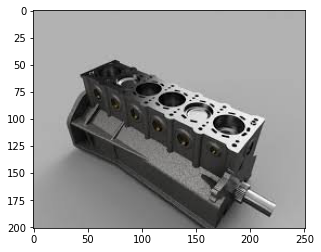

Engine Block


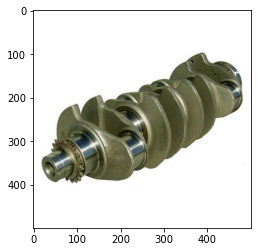

Crank Shaft


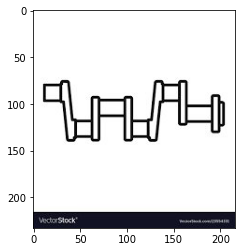

Crank Shaft


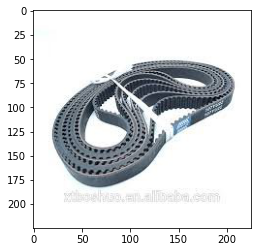

Timing Belt


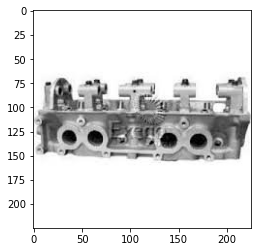

Cylinder Head


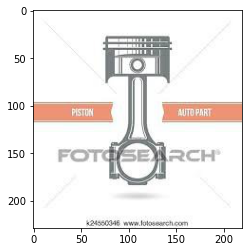

Piston


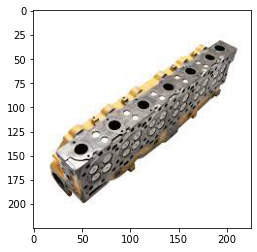

Cylinder Head


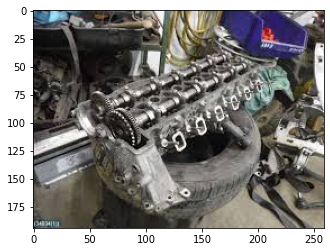

Engine Block


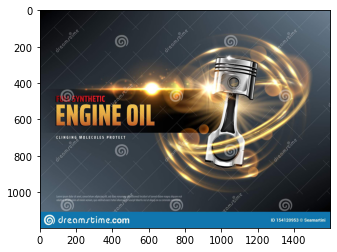

Piston


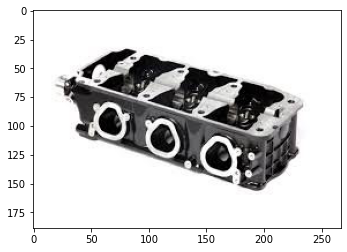

Cylinder Head


In [16]:
for i in range(10):
    imp = random.choice(all_images)
    get_prediction(imp)